<a href="https://colab.research.google.com/github/iiph1/229352-StatisticalLearning/blob/main/660510773_Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [ ]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range
label 0 =muffin ,1 = chihuahua

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform) #folder ของข้อมูลต้องแบ่ง folder ย่อย train,test

#### Split the dataset into training (80%), validation (20%)

### Hyperparameters
1. Learning rate
2. Batch size ต้องแบ่งเพราะ memory ไม่พอ
3. Epoch

In [ ]:
train_size = int(0.8 * len(dataset)) #แบ่งข้อมูล 80 %
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) #คำสั่งในการแบ่งข้อมูล

#### Load the datasets into DataLoader

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True) #shuffle ให้ได้ความหลากหลาย
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False) #แบ่งข้อมูลเป็นทีละ batch

#### Do the same for the test images

In [ ]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [ ]:
train_loader
#ต้องใส่ loop ถึงจะเห็นหน้าตา

In [ ]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


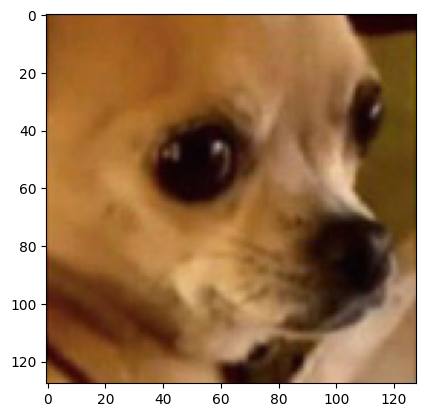

In [ ]:
plt.imshow(X[0].numpy().transpose(1,2,0))

In [ ]:
y #0=muffin,1=chihuahua

tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 1])

#### Visualize the first four images in the batch

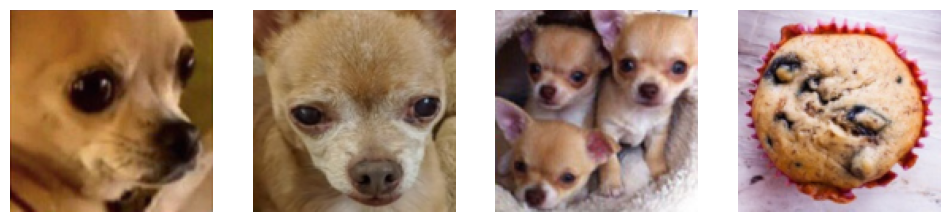

tensor([0, 0, 0, 1])


In [ ]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [ ]:
class SimpleLogisticRegression(nn.Module): #ทำ subclass  nn=Neural Network
  def __init__(self):
    super(SimpleLogisticRegression, self).__init__() #ใช้ superclass
    # (B, C, H, W) = (10,3,128,128) ทำแล้วควรใส่ขนาดกำกับด้วย
    self.flatten = nn.Flatten() #คลี่รูปภาพให้เป็นเวกเตอร์ด้วย layer ของ pytorch (10,49152)
    self.linear = nn.Linear(3 * 128 * 128, 1) #เปลี่ยนจาก input -> output ที่มี 1 layer (10,128)
    self.activation = nn.Sigmoid() #(10,1)

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear(x)
    x = self.activation(x)
    return x


### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [ ]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss() #binary cross entropy = loss function

#### Manually setting initial weights to zero for demonstration

In [ ]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [ ]:
# List to store the loss values for plotting list ไว้เก็บค่า loss funtion แต่ละตัว
train_losses = []
val_losses = []

#### Specify the learning rate

In [ ]:
learning_rate = 1e-3

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [ ]:
train_batches = iter(train_loader) #ดึงข้อมูลแต่ละ batch ออกมา
X, y = next(train_batches) #next อันนี้ batch แรก ถ้า next ถัดไป ก้จะเป็น batch ที่สอง

#### Make a prediction on the minibatch (Forward pass)

In [ ]:
y_hat = model(X)
y_hat = y_hat[:, 0] #tenser 2d -> 1d
y = y.to(torch.float32)#y int -> float
print(y_hat.shape)
print(y.shape)

#y_hat = y_hat[:, 0]
#y = y.to(torch.float32)

torch.Size([10])
torch.Size([10])


#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [ ]:
# Compute the loss
loss = criterion(y_hat, y)
train_losses.append(loss.item())

In [ ]:
train_losses

[0.6931471824645996]

#### Calculate the gradient (Backward pass)

In [ ]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
loss.backward()

In [ ]:
for parem in model.parameters():
  print(parem)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [ ]:
for parem in model.parameters():
  print(parem.grad)

tensor([[-0.0249, -0.0249, -0.0229,  ..., -0.0386, -0.0420, -0.0571]])
tensor([0.])


In [ ]:
model.parameters()

<generator object Module.parameters at 0x7bdd4057f060>

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [ ]:
# Manually update the weights using the gradient descent rule
with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad

# Zero the gradients after updating
model.zero_grad()

In [ ]:
for parem in model.parameters():
  print(parem.grad)

None
None


#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [ ]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [ ]:
print(train_losses)
print(val_losses)

[0.6931471824645996]
[0.7734036445617676]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

ตอนเอาไปใช้แนะนำให้เอา def ครอบ เป็น def train model (model,learning_rate) แล้วลบ learningrate ในโค้ดทิ้ง เขียน return เพิ่มด้วย

In [ ]:
def train_model(model, learning_rate):
    criterion = nn.BCELoss()

    with torch.no_grad():
        for layer in model.modules():
            if isinstance(layer, nn.Linear):
                layer.weight.zero_()
                layer.bias.zero_()

    train_losses = []
    val_losses = []

    for epoch in range(10):
        for X, y in train_loader:
            y_hat = model(X)
            y_hat = y_hat[:, 0]
            y = y.to(torch.float32)

            loss = criterion(y_hat, y)
            train_losses.append(loss.item())

            loss.backward()

            with torch.no_grad():
                for param in model.parameters():
                    param -= learning_rate * param.grad

            # Zero the gradients after updating
            model.zero_grad()

            with torch.no_grad():
                for X, y in val_loader:
                    y_hat = model(X)
                    y_hat = y_hat[:, 0]
                    y = y.to(torch.float32)
                    val_loss = criterion(y_hat, y)
                    val_losses.append(val_loss)

    # Plot the training and validation loss
    plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
    plt.title('Training and Validation Loss per Batch')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, train_losses, val_losses

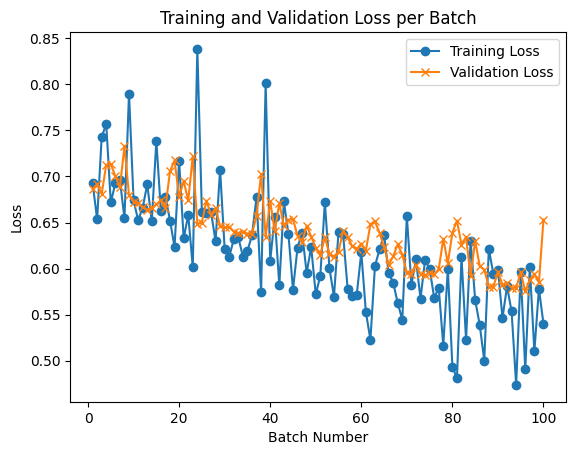

In [ ]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

ดูค่า loss บน validation set เป็นหลัก

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [ ]:
# Use this code to calculate test accuracy
# with torch.no_grad():
#   test_batches = iter(test_loader) #คำสั่งเรียกข้อมูลทั้งก้อน
#   X, y = next(test_batches)
#   y_hat = model(X)
#   y_hat = y_hat[:, 0]
#   y_hat = (y_hat > 0.5).float()  # the predictions
#   ##TODO: compute accuracy


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1=128, hidden_size2=64, hidden_size3=32):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.output = nn.Linear(hidden_size3, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
def train_model(model, learning_rate):
    criterion = nn.BCELoss()

    with torch.no_grad():
        for layer in model.modules():
            if isinstance(layer, nn.Linear):
                layer.weight.zero_()
                layer.bias.zero_()

    train_losses = []
    val_losses = []

    for epoch in range(10):
        for X, y in train_loader:
            y_hat = model(X)
            y_hat = y_hat[:, 0]
            y = y.to(torch.float32)

            loss = criterion(y_hat, y)
            train_losses.append(loss.item())

            loss.backward()

            with torch.no_grad():
                for param in model.parameters():
                    param -= learning_rate * param.grad

            # Zero the gradients after updating
            model.zero_grad()

            with torch.no_grad():
                for X, y in val_loader:
                    y_hat = model(X)
                    y_hat = y_hat[:, 0]
                    y = y.to(torch.float32)
                    val_loss = criterion(y_hat, y)
                    val_losses.append(val_loss)

    # Plot the training and validation loss
    plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
    plt.title('Training and Validation Loss per Batch')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, train_losses, val_losses

Training with learning rate = 0.01


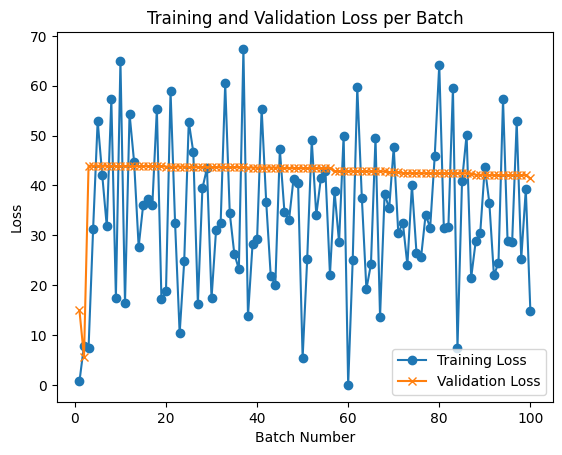

Training with learning rate = 0.001


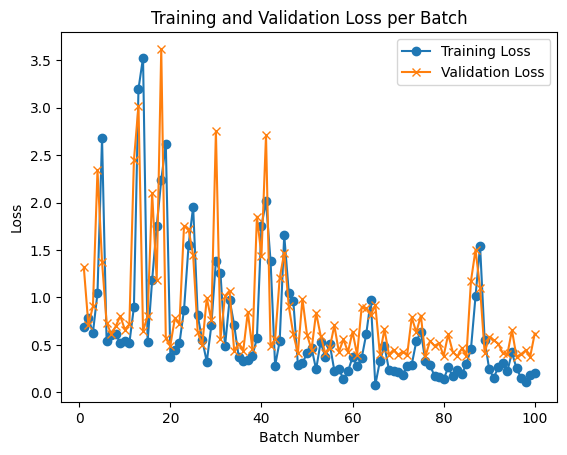

Training with learning rate = 0.0001


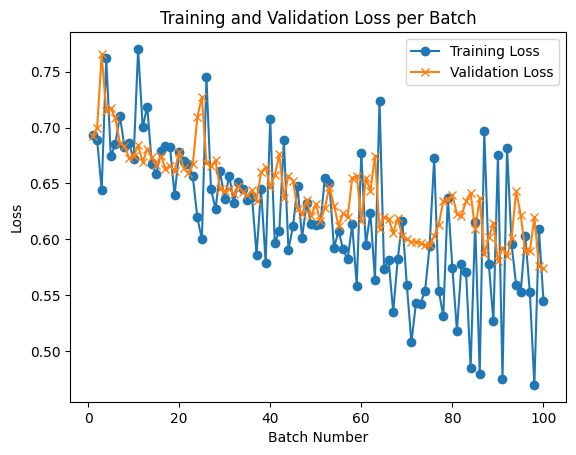

Training with learning rate = 1e-05


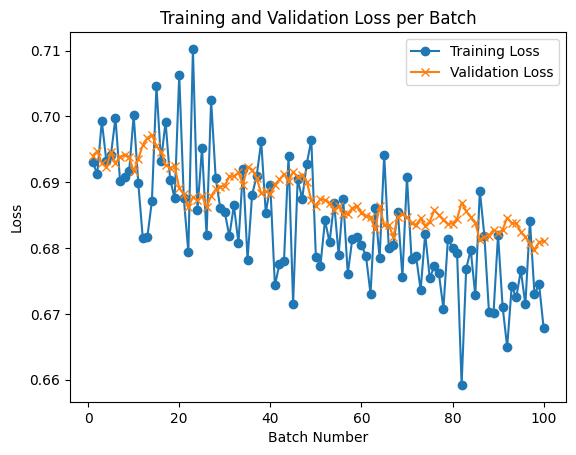

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
results = {}

for lr in learning_rates:
    print(f"Training with learning rate = {lr}")
    model = SimpleLogisticRegression()

    model, train_losses, val_losses = train_model(model, learning_rate=lr)

    results[lr] = (train_losses, val_losses)


2.1 เลือกใช้ learning rate = 1e-5 เนื่องจาก ค่า loss มีการลดลงอย่างต่อเนื่อง และกราฟเสถียร ไม่มีความผันผวนเท่ากับ lerning rate ค่าอื่นๆ

2.2 ถ้า learning rate ใหญ่เกินไป gradient descent จะกระโดดข้าม minimum ไปเรื่อย ๆ ส่งผลให้training loss ไม่ลดลง

2.3 ถ้า learning rate เล็กเกินไปโมเดลจะอัปเดต weight ทีละก้าวเล็กมาก ทำให้
 training loss ลดลงช้าต้องใช้ epoch จำนวนมากกว่าจะเข้าใกล้ minimum

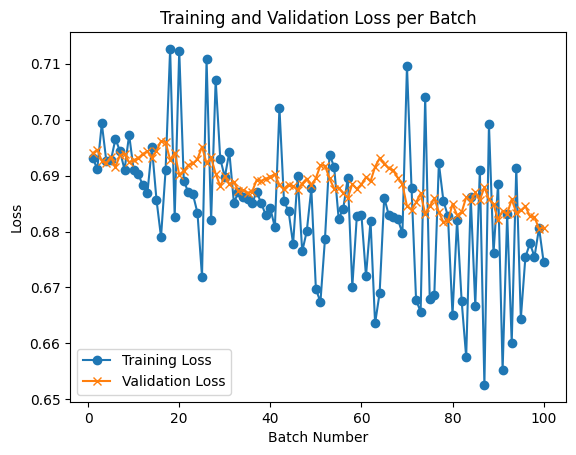

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define the SimpleLogisticRegression model class here
class SimpleLogisticRegression(nn.Module): #ทำ subclass  nn=Neural Network
  def __init__(self):
    super(SimpleLogisticRegression, self).__init__() #ใช้ superclass
    # (B, C, H, W) = (10,3,128,128) ทำแล้วควรใส่ขนาดกำกับด้วย
    self.flatten = nn.Flatten() #คลี่รูปภาพให้เป็นเวกเตอร์ด้วย layer ของ pytorch (10,49152)
    self.linear = nn.Linear(3 * 128 * 128, 1) #เปลี่ยนจาก input -> output ที่มี 1 layer (10,128)
    self.activation = nn.Sigmoid() #(10,1)

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear(x)
    x = self.activation(x)
    return x

model = SimpleLogisticRegression()
criterion = nn.BCELoss()

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-5

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Use this code to calculate test accuracy
def calculate_test_accuracy(model, test_loader):
  with torch.no_grad():
    test_batches = iter(test_loader) #คำสั่งเรียกข้อมูลทั้งก้อน
    X, y = next(test_batches)
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y_hat = (y_hat > 0.5).float()  # the predictions
    ##TODO: compute accuracy
    correct_predictions = (y_hat == y.to(torch.float32)).sum().item()
    accuracy = correct_predictions / len(y)
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy
calculate_test_accuracy(model, test_loader)

Test Accuracy: 0.6000


0.6

In [ ]:
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []

with torch.no_grad():
    for X, y in test_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        predicted_labels = (y_hat > 0.5).float()

        for i in range(len(y)):
            if predicted_labels[i] != y[i]:
                misclassified_images.append(X[i])
                misclassified_labels.append(y[i])
                misclassified_predictions.append(predicted_labels[i])

print(f"Found {len(misclassified_images)} misclassified images.")

Found 12 misclassified images.


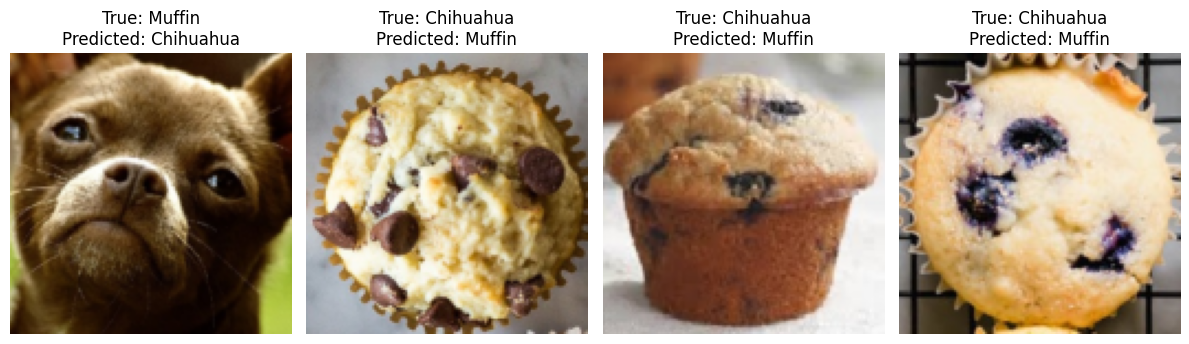

In [ ]:
import matplotlib.pyplot as plt

num_images_to_display = min(4, len(misclassified_images))

if num_images_to_display > 0:
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(12, 4))

    for i in range(num_images_to_display):
        img = misclassified_images[i].numpy().transpose(1, 2, 0)
        axes[i].imshow(img)
        true_label = "Chihuahua" if misclassified_labels[i].item() == 1 else "Muffin"
        predicted_label = "Chihuahua" if misclassified_predictions[i].item() == 1 else "Muffin"
        axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images found to display.")